Acknowledgement: This project was largely motivated by the work of Michelle Lochner et al. (ApJ Supplement Series, 225:31, 2016), which can be accessed via this [link](https://iopscience.iop.org/article/10.3847/0067-0049/225/2/31).

In [1]:
# Note that this notebook was run on Google Colab,
# therefore, mounting it to Phong's Google Drive was necessary.
# If one runs it via Jupyter, this is not needed.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Step 1: Data Analysis

First, we load datasets of both models.

In [39]:
# Model 1:
I_Ia = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeIa.csv').dropna()
I_Ibc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeIbc.csv').dropna()
I_II = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeII.csv').dropna()
I_skip = ['sn_name', 'sn_type', 'band']
I_labels = ['Ia', 'Ibc', 'II']

In [40]:
# Model 2:
II_Ia = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful[75].csv').dropna()
II_II = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful[68].csv').dropna()
II_IIn = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful.csv').dropna()
II_skip = {'supernova', 'type', 'band', 'n_obs', 'flux_scale', 'redshift'}
II_labels = ['Ia', 'II', 'IIn']

Next, we inspect the statistics of the features in each dataset.

In [35]:
def histogram_all(dfs, skip, labels):
    cols = [c for c in dfs[0].columns if c not in skip]

    n = len(cols)
    rows = (n + 2) // 2    # number of rows needed
    fig, axes = plt.subplots(rows, 2, figsize=(12, 3*rows))

    axes = axes.flatten()  # flatten so we can index axis[i]

    for i, column in enumerate(cols):
        ax = axes[i]

        # Plot histograms from all three datasets
        for j in range(len(dfs)):
            ax.hist(dfs[j][column], bins=30, alpha=0.5, label=labels[j])

        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        ax.legend()

    # Hide unused axes if columns not multiple of 3
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

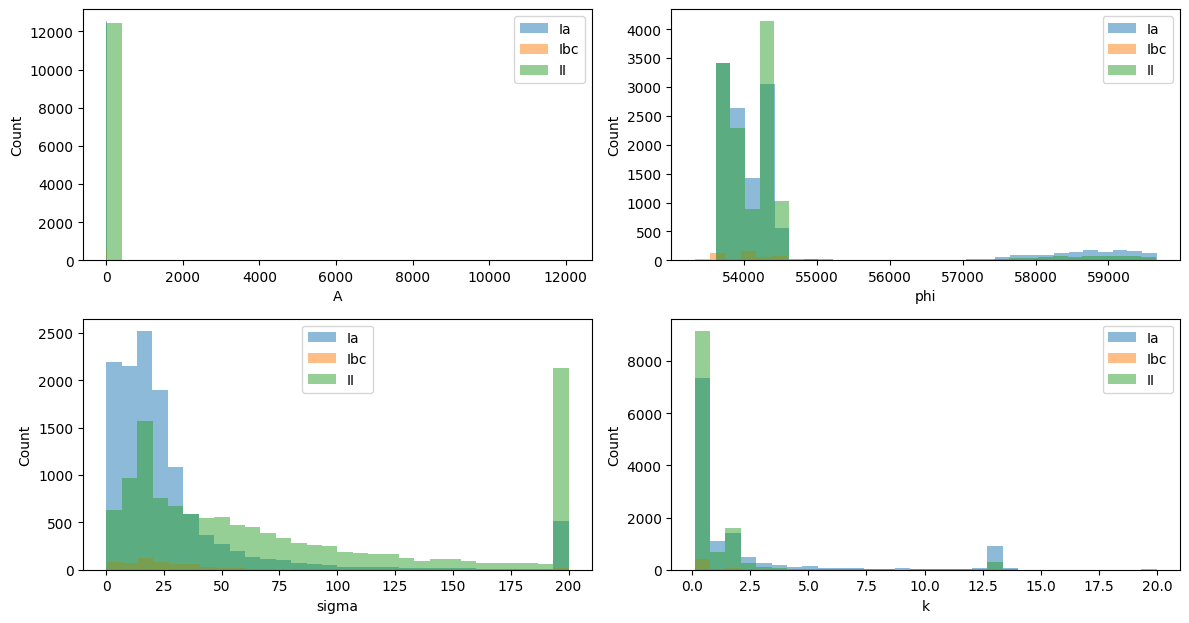

In [41]:
# Histograms for Model 1
histogram_all([I_Ia, I_Ibc, I_II], I_skip, I_labels)

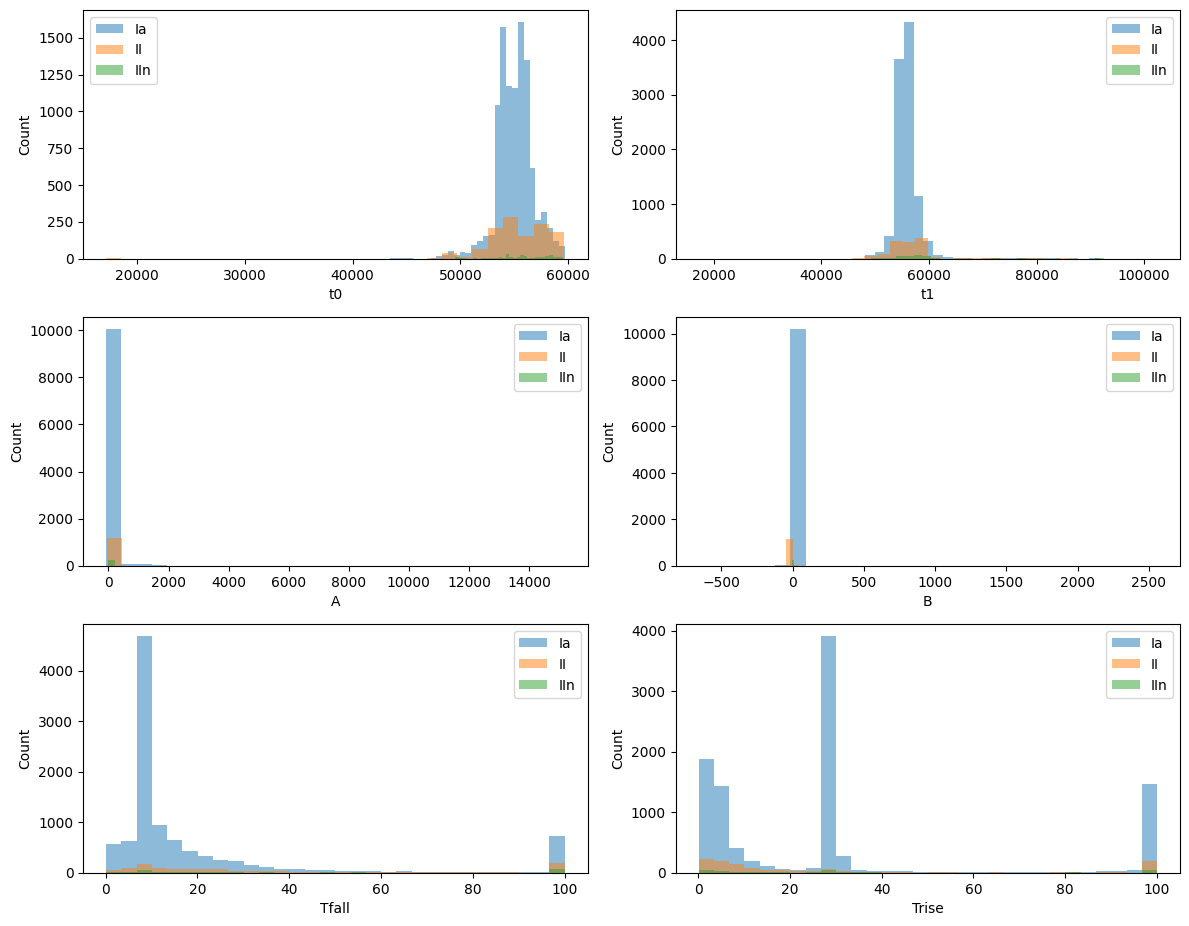

In [37]:
# Histograms for Model 2
histogram_all([II_Ia,II_II,II_IIn],II_skip,II_labels)

Both these datasets show presence of outliers, which can skew the model. We use clipping technique to squeeze both dataset to their 25-75quantile intervals.

In [42]:
def clipping(dfs, skip):
    dfs_clipped = []
    feature_cols = [c for c in dfs[0].columns if c not in skip]

    for df in dfs:
        df_copy = df.copy()

        # Compute IQR only on feature columns
        Q1 = df_copy[feature_cols].quantile(0.25)
        Q3 = df_copy[feature_cols].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Clip only the feature columns
        df_copy[feature_cols] = df_copy[feature_cols].clip(lower=lower, upper=upper, axis=1)

        dfs_clipped.append(df_copy)

    return dfs_clipped

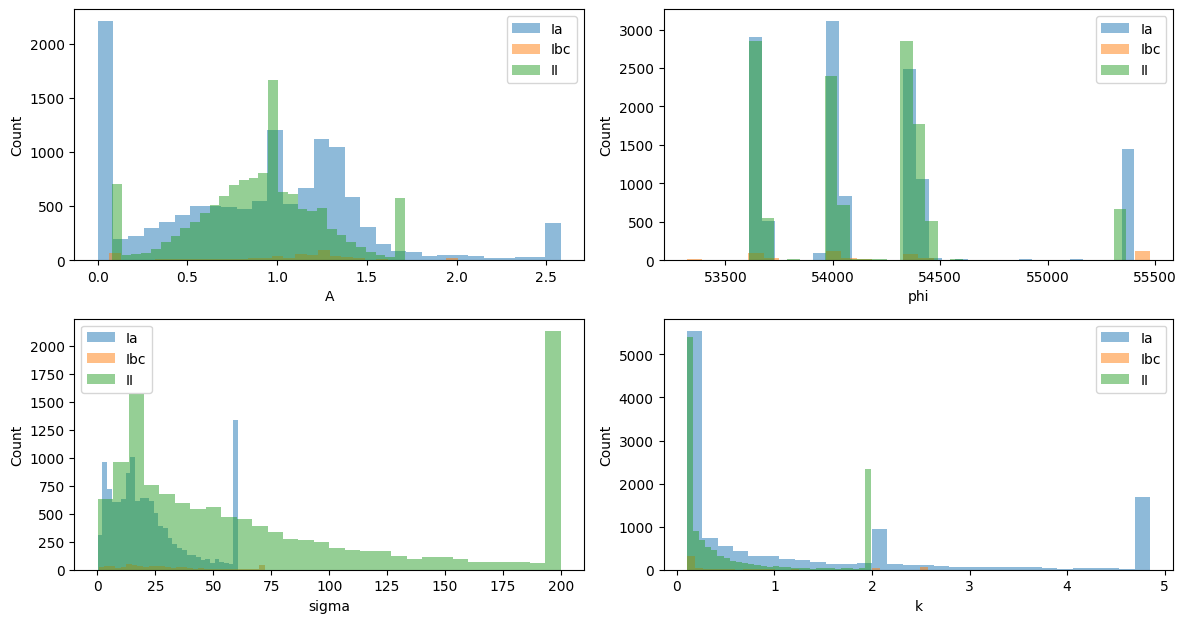

In [50]:
I_Ia_clip, I_Ibc_clip, I_II_clip = clipping([I_Ia,I_Ibc,I_II], I_skip)
histogram_all([I_Ia_clip, I_Ibc_clip, I_II_clip], I_skip, I_labels)

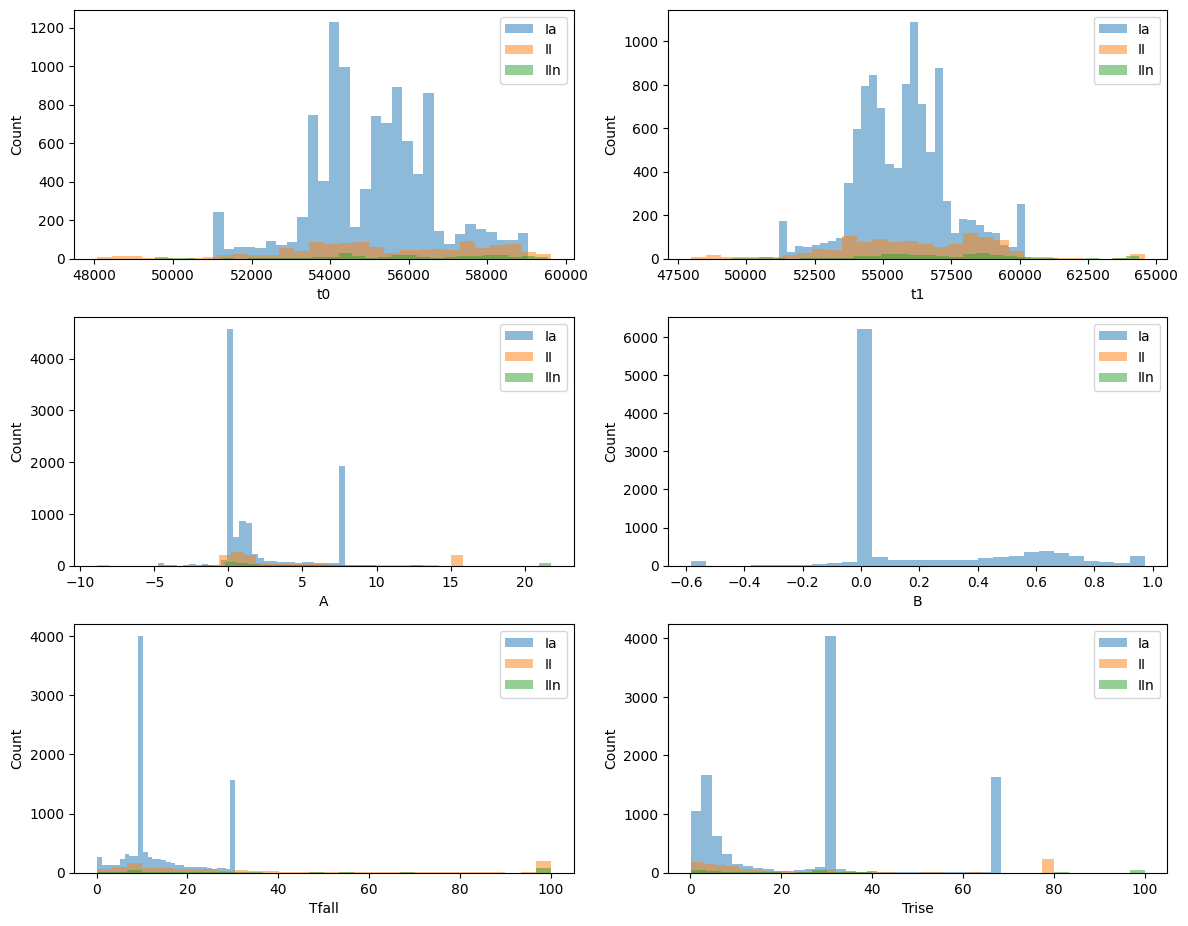

In [53]:
II_Ia_clip, II_II_clip, II_IIn_clip = clipping([II_Ia,II_II,II_IIn], II_skip)
histogram_all([II_Ia_clip, II_II_clip, II_IIn_clip], II_skip, II_labels)

Step 2: Prepare for training

In [67]:
from sklearn.preprocessing import RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

First, we define a function for evaluating performance of a model.

In [28]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names):
  # Print out metrics
  print("The training set:")
  y_train_pred = model.predict(X_train)
  print("\n Validation accuracy: ", accuracy_score(y_train, y_train_pred))
  print("\n Classification report:\n ",classification_report(y_train, y_train_pred))
  print("\n Confusion matrix:\n", confusion_matrix(y_train, y_train_pred))

  print("\nThe test set:")
  y_test_pred = model.predict(X_test)
  print("\n Validation accuracy: ", accuracy_score(y_test, y_test_pred))
  print("\n Classification report:\n ",classification_report(y_test, y_test_pred))
  print("\n Confusion matrix: \n", confusion_matrix(y_test, y_test_pred))

  # Plot ROC curve
  classes = np.unique(y_test)
  n_classes = len(classes)
  y_test_bin = label_binarize(y_test, classes=classes)
  y_score = model.predict_proba(X_test)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(7,6))
  colors = plt.cm.get_cmap('Set1', n_classes)
  for i in range(n_classes):
    label = f"Class {i}" if class_names is None else class_names[i]
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0,1], [0,1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

Second, we prepare features and labels.

In [54]:
# Model 1:
# Combining into a single dataset
I = pd.concat([I_Ia_clip, I_Ibc_clip, I_II_clip], ignore_index=True)
I = I.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_feature_cols = [c for c in I.columns if c not in I_skip]
I_X = I[I_feature_cols]

# Extracting labels
I_y = I['sn_type']
#print("Unique mapped labels:", I_y.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II
I_name_Ia = ['Ia','IaQ','Ia_Pec']
I_name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']
I_y = I_y.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else 1))

# Split data and scale
I_X_train, I_X_test, I_y_train, I_y_test = train_test_split(
    I_X, I_y,
    test_size=0.2,
    random_state=42,
    stratify=I_y,
    shuffle=True
)

I_scaler = RobustScaler()
I_X_train = I_scaler.fit_transform(I_X_train)
I_X_test = I_scaler.transform(I_X_test)

# Count examples in classes
print("Total:\n",pd.Series(I_y).value_counts())
print("Train:\n",pd.Series(I_y_train).value_counts())
print("Test:\n",pd.Series(I_y_test).value_counts())

Total:
 sn_type
0    12590
2    12447
1      600
Name: count, dtype: int64
Train:
 sn_type
0    10072
2     9957
1      480
Name: count, dtype: int64
Test:
 sn_type
0    2518
2    2490
1     120
Name: count, dtype: int64


In [55]:
# Model 2:
# Combining into a single dataset
II = pd.concat([II_Ia_clip, II_II_clip, II_IIn_clip], ignore_index=True)
II = II.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_feature_cols = [c for c in II.columns if c not in II_skip]
II_X = II[II_feature_cols]

# Extracting labels
II_y = II['type']
#print("Unique mapped labels:", II_y.unique())

# Encode categorical labels
II_y = II_y.map({'Ia': 0, 'II': 1, 'IIn': 2})

# Split data and scale
II_X_train, II_X_test, II_y_train, II_y_test = train_test_split(
    II_X, II_y,
    test_size=0.2,
    random_state=42,
    stratify=II_y,
    shuffle=True
)

II_scaler = RobustScaler()
II_X_train = II_scaler.fit_transform(II_X_train)
II_X_test = II_scaler.transform(II_X_test)

# Count examples in classes
print("Total:\n",pd.Series(II_y).value_counts())
print("Train:\n",pd.Series(II_y_train).value_counts())
print("Test:\n",pd.Series(II_y_test).value_counts())

Total:
 type
0    10234
1     1174
2      255
Name: count, dtype: int64
Train:
 type
0    8187
1     939
2     204
Name: count, dtype: int64
Test:
 type
0    2047
1     235
2      51
Name: count, dtype: int64


It can be seen that both datasets have very strong imbalance between classes. We try downsampling.

In [57]:
# Model 1:
# Combining into a single dataset
I_down = pd.concat([I_Ia_clip.sample(1000), I_Ibc_clip, I_II_clip.sample(1000)], ignore_index=True)
I_down = I_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_X_down = I_down[I_feature_cols]

# Extracting labels
I_y_down = I_down['sn_type']
#print("Unique mapped labels:", I_y_down.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II
I_y_down = I_y_down.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else 1))

# Split data and scale
I_X_train_down, I_X_test_down, I_y_train_down, I_y_test_down = train_test_split(
    I_X_down, I_y_down,
    test_size=0.2,
    random_state=42,
    stratify=I_y_down,
    shuffle=True
)

I_scaler_down = RobustScaler()
I_X_train_down = I_scaler_down.fit_transform(I_X_train_down)
I_X_test_down = I_scaler_down.transform(I_X_test_down)

# Count examples in classes
print("Total:\n",pd.Series(I_y_down).value_counts())
print("Train:\n",pd.Series(I_y_train_down).value_counts())
print("Test:\n",pd.Series(I_y_test_down).value_counts())

Total:
 sn_type
0    1000
2    1000
1     600
Name: count, dtype: int64
Train:
 sn_type
0    800
2    800
1    480
Name: count, dtype: int64
Test:
 sn_type
2    200
0    200
1    120
Name: count, dtype: int64


In [58]:
# Model 2:
# Combining into a single dataset
II_down = pd.concat([II_Ia_clip.sample(2000), II_II_clip, II_IIn_clip], ignore_index=True)
II_down = II_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_X_down = II_down[II_feature_cols]

# Extracting labels
II_y_down = II_down['type']
#print("Unique mapped labels:", II_y.unique())

# Encode categorical labels
II_y_down = II_y_down.map({'Ia': 0, 'II': 1, 'IIn': 2})

# Split data and scale
II_X_train_down, II_X_test_down, II_y_train_down, II_y_test_down = train_test_split(
    II_X_down, II_y_down,
    test_size=0.2,
    random_state=42,
    stratify=II_y_down,
    shuffle=True
)

II_scaler_down = RobustScaler()
II_X_train_down = II_scaler_down.fit_transform(II_X_train_down)
II_X_test_down = II_scaler_down.transform(II_X_test_down)

# Count examples in classes
print("Total:\n",pd.Series(II_y_down).value_counts())
print("Train:\n",pd.Series(II_y_train_down).value_counts())
print("Test:\n",pd.Series(II_y_test_down).value_counts())

Total:
 type
0    2000
1    1174
2     255
Name: count, dtype: int64
Train:
 type
0    1600
1     939
2     204
Name: count, dtype: int64
Test:
 type
0    400
1    235
2     51
Name: count, dtype: int64


Step 3: Multi-layer perceptron classifier

In [65]:
from sklearn.neural_network import MLPClassifier

Iteration 1, loss = 0.53864589
Validation score: 0.759629
Iteration 2, loss = 0.47755937
Validation score: 0.792296
Iteration 3, loss = 0.45593000
Validation score: 0.796685
Iteration 4, loss = 0.44269295
Validation score: 0.804486
Iteration 5, loss = 0.43708961
Validation score: 0.803998
Iteration 6, loss = 0.43203649
Validation score: 0.802535
Iteration 7, loss = 0.42742401
Validation score: 0.807411
Iteration 8, loss = 0.42611109
Validation score: 0.816187
Iteration 9, loss = 0.42231804
Validation score: 0.805948
Iteration 10, loss = 0.42067391
Validation score: 0.809849
Iteration 11, loss = 0.41876101
Validation score: 0.813262
Iteration 12, loss = 0.41557301
Validation score: 0.812774
Iteration 13, loss = 0.41743250
Validation score: 0.808386
Iteration 14, loss = 0.41169494
Validation score: 0.815700
Iteration 15, loss = 0.41192654
Validation score: 0.812774
Iteration 16, loss = 0.41034974
Validation score: 0.813262
Iteration 17, loss = 0.40741015
Validation score: 0.811312
Iterat

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-309817868.py:29: MatplotlibDep

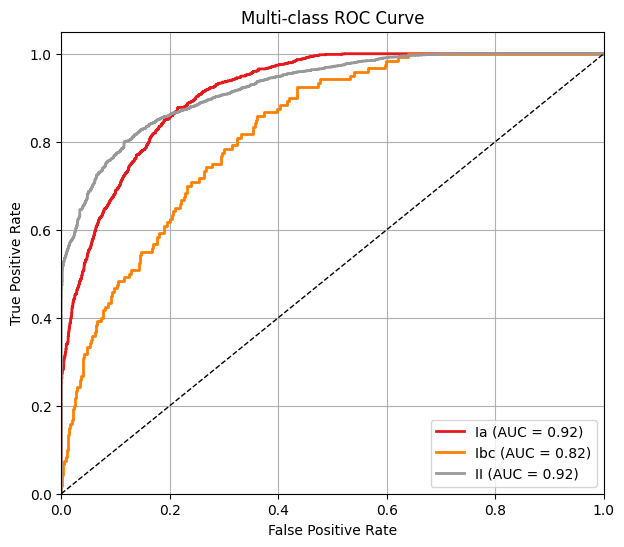

In [59]:
# Model 1 without downsampling
I_mlp = MLPClassifier(
    hidden_layer_sizes=(128,64,64),
    activation='relu',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    shuffle=True,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

I_mlp.fit(I_X_train, I_y_train)
evaluate_model(I_mlp, I_X_train, I_y_train, I_X_test, I_y_test, I_labels)

Iteration 1, loss = 0.93997929
Validation score: 0.524038
Iteration 2, loss = 0.88522780
Validation score: 0.509615
Iteration 3, loss = 0.86259515
Validation score: 0.509615
Iteration 4, loss = 0.84530812
Validation score: 0.509615
Iteration 5, loss = 0.82948814
Validation score: 0.519231
Iteration 6, loss = 0.81745036
Validation score: 0.572115
Iteration 7, loss = 0.80505969
Validation score: 0.538462
Iteration 8, loss = 0.79663129
Validation score: 0.581731
Iteration 9, loss = 0.78756829
Validation score: 0.572115
Iteration 10, loss = 0.78169730
Validation score: 0.567308
Iteration 11, loss = 0.77720117
Validation score: 0.620192
Iteration 12, loss = 0.77141015
Validation score: 0.634615
Iteration 13, loss = 0.76657673
Validation score: 0.596154
Iteration 14, loss = 0.76015378
Validation score: 0.634615
Iteration 15, loss = 0.75925519
Validation score: 0.625000
Iteration 16, loss = 0.75469077
Validation score: 0.615385
Iteration 17, loss = 0.75049691
Validation score: 0.620192
Iterat

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


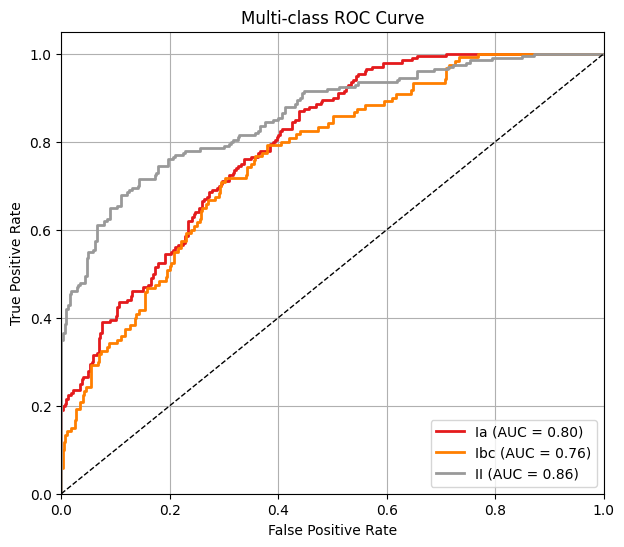

In [60]:
# Model 1 with downsampling
I_mlp_down = MLPClassifier(
    hidden_layer_sizes=(32,32),
    activation='relu',
    alpha=0.001,
    batch_size=16,
    learning_rate='adaptive',
    max_iter=500,
    shuffle=True,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

I_mlp_down.fit(I_X_train_down, I_y_train_down)
evaluate_model(I_mlp_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_labels)

Iteration 1, loss = 0.35813640
Validation score: 0.919614
Iteration 2, loss = 0.25527350
Validation score: 0.917471
Iteration 3, loss = 0.23660282
Validation score: 0.914255
Iteration 4, loss = 0.22845051
Validation score: 0.922830
Iteration 5, loss = 0.22002756
Validation score: 0.924973
Iteration 6, loss = 0.21217897
Validation score: 0.921758
Iteration 7, loss = 0.20687027
Validation score: 0.920686
Iteration 8, loss = 0.20088661
Validation score: 0.931404
Iteration 9, loss = 0.19333387
Validation score: 0.922830
Iteration 10, loss = 0.19057011
Validation score: 0.929260
Iteration 11, loss = 0.18901399
Validation score: 0.934620
Iteration 12, loss = 0.18509524
Validation score: 0.930332
Iteration 13, loss = 0.18100434
Validation score: 0.926045
Iteration 14, loss = 0.18022515
Validation score: 0.933548
Iteration 15, loss = 0.17664469
Validation score: 0.931404
Iteration 16, loss = 0.17162620
Validation score: 0.933548
Iteration 17, loss = 0.17023679
Validation score: 0.932476
Iterat

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


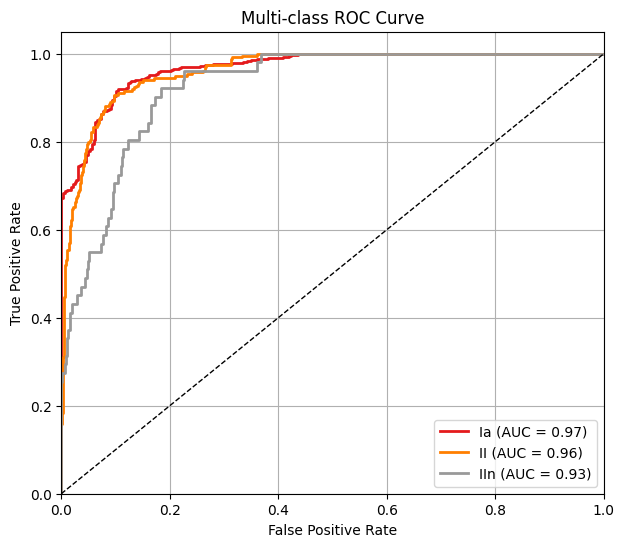

In [61]:
# Model 2 without downsampling
II_mlp = MLPClassifier(
    hidden_layer_sizes=(128,64,32),
    activation='relu',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    shuffle=True,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

II_mlp.fit(II_X_train, II_y_train)
evaluate_model(II_mlp, II_X_train, II_y_train, II_X_test, II_y_test, II_labels)

Iteration 1, loss = 0.68134854
Validation score: 0.712727
Iteration 2, loss = 0.57705154
Validation score: 0.720000
Iteration 3, loss = 0.54038852
Validation score: 0.745455
Iteration 4, loss = 0.51230482
Validation score: 0.774545
Iteration 5, loss = 0.49824582
Validation score: 0.781818
Iteration 6, loss = 0.47675317
Validation score: 0.814545
Iteration 7, loss = 0.46384041
Validation score: 0.810909
Iteration 8, loss = 0.45061446
Validation score: 0.814545
Iteration 9, loss = 0.44113553
Validation score: 0.825455
Iteration 10, loss = 0.43168749
Validation score: 0.825455
Iteration 11, loss = 0.42531747
Validation score: 0.836364
Iteration 12, loss = 0.41519083
Validation score: 0.832727
Iteration 13, loss = 0.40751444
Validation score: 0.836364
Iteration 14, loss = 0.40413533
Validation score: 0.840000
Iteration 15, loss = 0.39495432
Validation score: 0.832727
Iteration 16, loss = 0.39036270
Validation score: 0.836364
Iteration 17, loss = 0.38585994
Validation score: 0.847273
Iterat

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


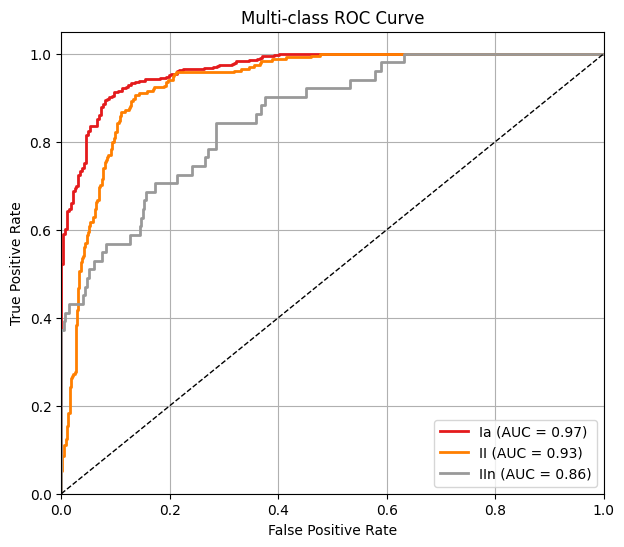

In [62]:
# Model 2 with downsampling
II_mlp_down = MLPClassifier(
    hidden_layer_sizes=(128,64),
    activation='relu',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=500,
    shuffle=True,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

II_mlp_down.fit(II_X_train_down, II_y_train_down)
evaluate_model(II_mlp_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_labels)

Observation: Model 2 outperforms Model 1 with or without downsampling. Downsampling makes it worse for the classifier.

Step 4: Support vector machine classifier

In [68]:
from sklearn.svm import SVC

The training set:

 Validation accuracy:  0.6243600370569018

 Classification report:
                precision    recall  f1-score   support

           0       0.74      0.60      0.66     10072
           1       0.07      0.71      0.12       480
           2       0.87      0.65      0.74      9957

    accuracy                           0.62     20509
   macro avg       0.56      0.65      0.51     20509
weighted avg       0.79      0.62      0.69     20509


 Confusion matrix:
 [[6024 3151  897]
 [  89  342   49]
 [1999 1519 6439]]

The test set:

 Validation accuracy:  0.6281201248049922

 Classification report:
                precision    recall  f1-score   support

           0       0.75      0.61      0.67      2518
           1       0.06      0.66      0.12       120
           2       0.87      0.64      0.74      2490

    accuracy                           0.63      5128
   macro avg       0.56      0.64      0.51      5128
weighted avg       0.79      0.63      0.69 

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


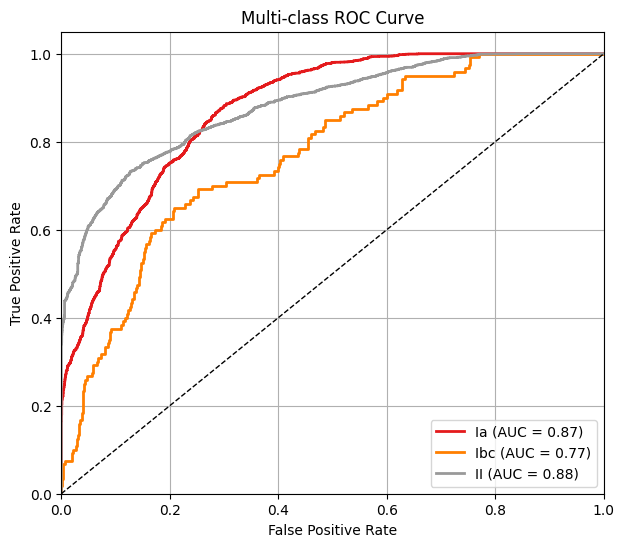

In [69]:
# Model 1 without downsampling
I_svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

I_svm.fit(I_X_train, I_y_train)
evaluate_model(I_svm, I_X_train, I_y_train, I_X_test, I_y_test, I_labels)

The training set:

 Validation accuracy:  0.6

 Classification report:
                precision    recall  f1-score   support

           0       0.62      0.51      0.55       800
           1       0.43      0.69      0.53       480
           2       0.77      0.64      0.70       800

    accuracy                           0.60      2080
   macro avg       0.61      0.61      0.60      2080
weighted avg       0.63      0.60      0.61      2080


 Confusion matrix:
 [[404 303  93]
 [ 94 329  57]
 [158 127 515]]

The test set:

 Validation accuracy:  0.6115384615384616

 Classification report:
                precision    recall  f1-score   support

           0       0.66      0.46      0.54       200
           1       0.42      0.69      0.52       120
           2       0.78      0.71      0.74       200

    accuracy                           0.61       520
   macro avg       0.62      0.62      0.60       520
weighted avg       0.65      0.61      0.62       520


 Confusion m

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


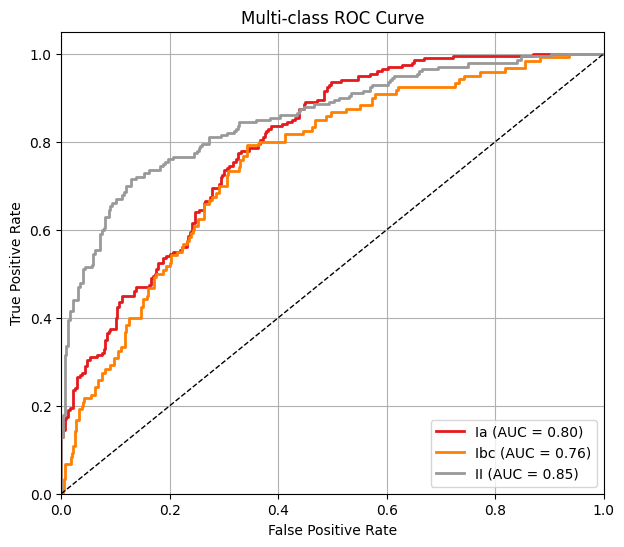

In [70]:
# Model 1 with downsampling
I_svm_down = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

I_svm_down.fit(I_X_train_down, I_y_train_down)
evaluate_model(I_svm_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_labels)

The training set:

 Validation accuracy:  0.8404072883172562

 Classification report:
                precision    recall  f1-score   support

           0       0.97      0.87      0.92      8187
           1       0.50      0.58      0.54       939
           2       0.18      0.75      0.29       204

    accuracy                           0.84      9330
   macro avg       0.55      0.74      0.58      9330
weighted avg       0.90      0.84      0.87      9330


 Confusion matrix:
 [[7144  522  521]
 [ 213  543  183]
 [  25   25  154]]

The test set:

 Validation accuracy:  0.833690527218174

 Classification report:
                precision    recall  f1-score   support

           0       0.97      0.87      0.92      2047
           1       0.50      0.59      0.54       235
           2       0.11      0.47      0.18        51

    accuracy                           0.83      2333
   macro avg       0.53      0.64      0.55      2333
weighted avg       0.90      0.83      0.86  

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


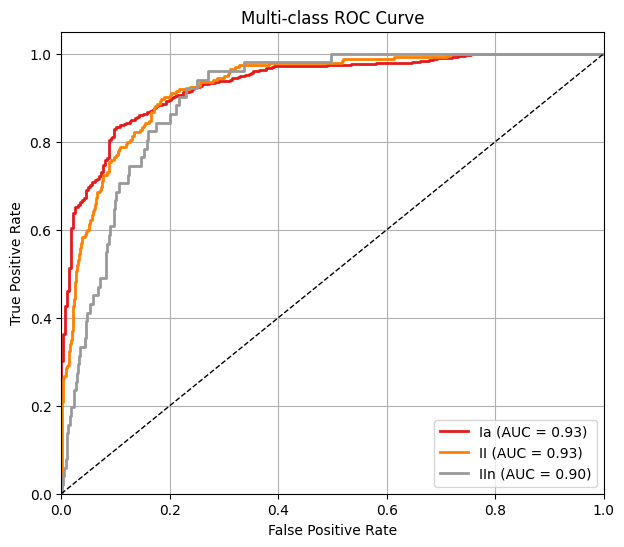

In [71]:
# Model 2 without downsampling
II_svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

II_svm.fit(II_X_train, II_y_train)
evaluate_model(II_svm, II_X_train, II_y_train, II_X_test, II_y_test, II_labels)

The training set:

 Validation accuracy:  0.5585125774699234

 Classification report:
                precision    recall  f1-score   support

           0       1.00      0.37      0.54      1600
           1       0.44      1.00      0.61       939
           2       0.00      0.00      0.00       204

    accuracy                           0.56      2743
   macro avg       0.48      0.46      0.38      2743
weighted avg       0.73      0.56      0.52      2743


 Confusion matrix:
 [[ 593 1007    0]
 [   0  939    0]
 [   0  204    0]]

The test set:

 Validation accuracy:  0.5612244897959183

 Classification report:
                precision    recall  f1-score   support

           0       1.00      0.38      0.55       400
           1       0.44      1.00      0.61       235
           2       0.00      0.00      0.00        51

    accuracy                           0.56       686
   macro avg       0.48      0.46      0.39       686
weighted avg       0.73      0.56      0.53 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

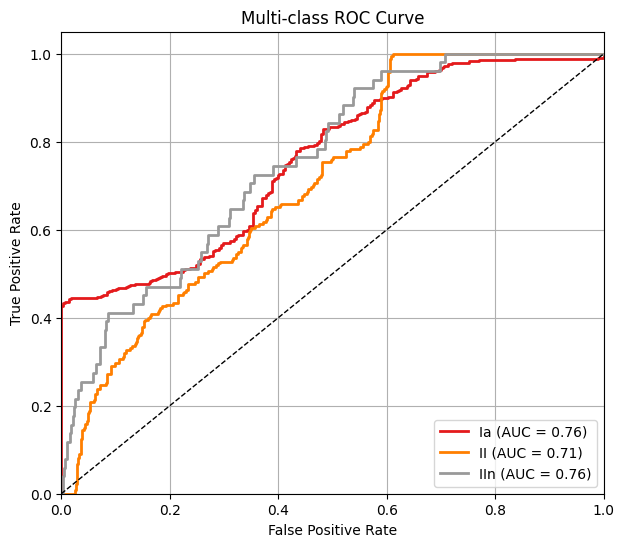

In [81]:
# Model 2 with downsampling
II_svm_down = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

II_svm_down.fit(II_X_train_down, II_y_train_down)
evaluate_model(II_svm_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_labels)

Observation: Model 2 outperforms Model 1 without downsampling. Downsampling makes it worse for the classifier.

Step 5: Boosted decision tree classifier

In [75]:
from xgboost import XGBClassifier

[0]	validation_0-mlogloss:0.94531
[1]	validation_0-mlogloss:0.91589
[2]	validation_0-mlogloss:0.88148
[3]	validation_0-mlogloss:0.84925
[4]	validation_0-mlogloss:0.82207
[5]	validation_0-mlogloss:0.79639
[6]	validation_0-mlogloss:0.76991
[7]	validation_0-mlogloss:0.75060
[8]	validation_0-mlogloss:0.72692
[9]	validation_0-mlogloss:0.70467
[10]	validation_0-mlogloss:0.68621
[11]	validation_0-mlogloss:0.66724
[12]	validation_0-mlogloss:0.65028
[13]	validation_0-mlogloss:0.63301
[14]	validation_0-mlogloss:0.61898
[15]	validation_0-mlogloss:0.60645
[16]	validation_0-mlogloss:0.59480
[17]	validation_0-mlogloss:0.58219
[18]	validation_0-mlogloss:0.57027
[19]	validation_0-mlogloss:0.55900
[20]	validation_0-mlogloss:0.54737
[21]	validation_0-mlogloss:0.53713
[22]	validation_0-mlogloss:0.52777
[23]	validation_0-mlogloss:0.51761
[24]	validation_0-mlogloss:0.50899
[25]	validation_0-mlogloss:0.49982
[26]	validation_0-mlogloss:0.49272
[27]	validation_0-mlogloss:0.48653
[28]	validation_0-mlogloss:0.4

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


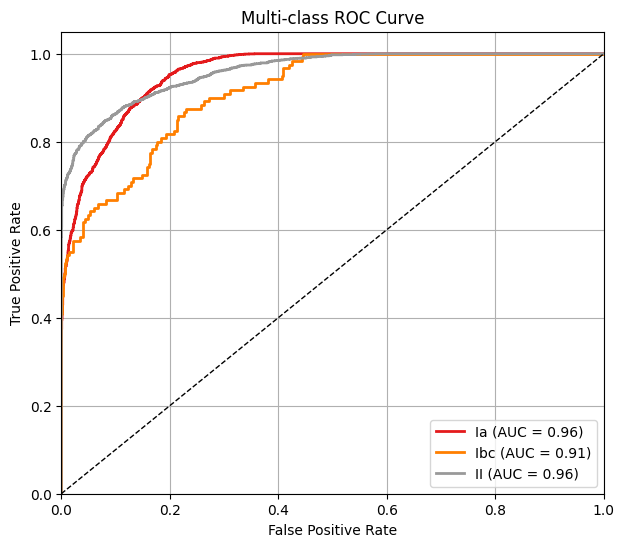

In [77]:
# Model 1 without downsampling
I_bdt = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

I_bdt.fit(I_X_train, I_y_train, eval_set=[(I_X_test, I_y_test)])
evaluate_model(I_bdt, I_X_train, I_y_train, I_X_test, I_y_test, I_labels)

[0]	validation_0-mlogloss:1.05843
[1]	validation_0-mlogloss:1.03610
[2]	validation_0-mlogloss:1.00976
[3]	validation_0-mlogloss:0.98657
[4]	validation_0-mlogloss:0.96682
[5]	validation_0-mlogloss:0.94520
[6]	validation_0-mlogloss:0.92502
[7]	validation_0-mlogloss:0.91031
[8]	validation_0-mlogloss:0.89283
[9]	validation_0-mlogloss:0.87509
[10]	validation_0-mlogloss:0.86135
[11]	validation_0-mlogloss:0.84571
[12]	validation_0-mlogloss:0.83282
[13]	validation_0-mlogloss:0.81956
[14]	validation_0-mlogloss:0.80682
[15]	validation_0-mlogloss:0.79545
[16]	validation_0-mlogloss:0.78575
[17]	validation_0-mlogloss:0.77587
[18]	validation_0-mlogloss:0.76628
[19]	validation_0-mlogloss:0.75641
[20]	validation_0-mlogloss:0.74578
[21]	validation_0-mlogloss:0.73731
[22]	validation_0-mlogloss:0.72958
[23]	validation_0-mlogloss:0.72071
[24]	validation_0-mlogloss:0.71258
[25]	validation_0-mlogloss:0.70439
[26]	validation_0-mlogloss:0.69744
[27]	validation_0-mlogloss:0.69171
[28]	validation_0-mlogloss:0.6

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


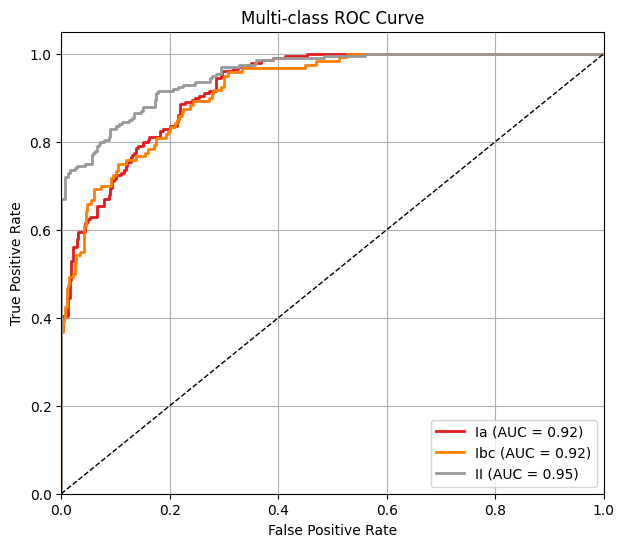

In [78]:
# Model 1 with downsampling
I_bdt_down = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

I_bdt_down.fit(I_X_train_down, I_y_train_down, eval_set=[(I_X_test_down, I_y_test_down)])
evaluate_model(I_bdt_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_labels)

[0]	validation_0-mlogloss:0.70095
[1]	validation_0-mlogloss:0.67212
[2]	validation_0-mlogloss:0.64523
[3]	validation_0-mlogloss:0.61982
[4]	validation_0-mlogloss:0.59475
[5]	validation_0-mlogloss:0.57297
[6]	validation_0-mlogloss:0.55198
[7]	validation_0-mlogloss:0.53207
[8]	validation_0-mlogloss:0.51338
[9]	validation_0-mlogloss:0.49617
[10]	validation_0-mlogloss:0.47886
[11]	validation_0-mlogloss:0.46284
[12]	validation_0-mlogloss:0.44693
[13]	validation_0-mlogloss:0.43218
[14]	validation_0-mlogloss:0.41862
[15]	validation_0-mlogloss:0.40676
[16]	validation_0-mlogloss:0.39427
[17]	validation_0-mlogloss:0.38323
[18]	validation_0-mlogloss:0.37184
[19]	validation_0-mlogloss:0.36155
[20]	validation_0-mlogloss:0.35205
[21]	validation_0-mlogloss:0.34286
[22]	validation_0-mlogloss:0.33396
[23]	validation_0-mlogloss:0.32592
[24]	validation_0-mlogloss:0.31825
[25]	validation_0-mlogloss:0.31080
[26]	validation_0-mlogloss:0.30306
[27]	validation_0-mlogloss:0.29636
[28]	validation_0-mlogloss:0.2

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


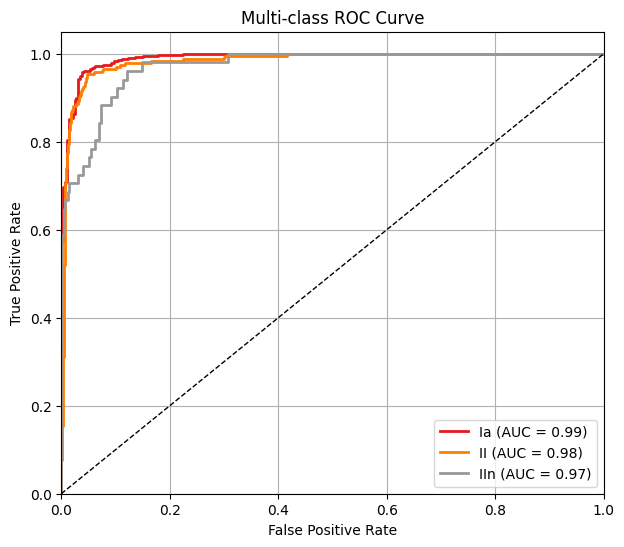

In [79]:
# Model 2 without downsampling
II_bdt = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

II_bdt.fit(II_X_train, II_y_train, eval_set=[(II_X_test, II_y_test)])
evaluate_model(II_bdt, II_X_train, II_y_train, II_X_test, II_y_test, II_labels)

[0]	validation_0-mlogloss:0.95634
[1]	validation_0-mlogloss:0.92752
[2]	validation_0-mlogloss:0.89834
[3]	validation_0-mlogloss:0.87135
[4]	validation_0-mlogloss:0.84525
[5]	validation_0-mlogloss:0.81947
[6]	validation_0-mlogloss:0.79684
[7]	validation_0-mlogloss:0.77498
[8]	validation_0-mlogloss:0.75464
[9]	validation_0-mlogloss:0.73410
[10]	validation_0-mlogloss:0.71395
[11]	validation_0-mlogloss:0.69622
[12]	validation_0-mlogloss:0.67833
[13]	validation_0-mlogloss:0.66189
[14]	validation_0-mlogloss:0.64669
[15]	validation_0-mlogloss:0.63269
[16]	validation_0-mlogloss:0.61923
[17]	validation_0-mlogloss:0.60566
[18]	validation_0-mlogloss:0.59223
[19]	validation_0-mlogloss:0.58039
[20]	validation_0-mlogloss:0.56909
[21]	validation_0-mlogloss:0.55827
[22]	validation_0-mlogloss:0.54872
[23]	validation_0-mlogloss:0.53872
[24]	validation_0-mlogloss:0.52953
[25]	validation_0-mlogloss:0.52077
[26]	validation_0-mlogloss:0.51194
[27]	validation_0-mlogloss:0.50386
[28]	validation_0-mlogloss:0.4

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


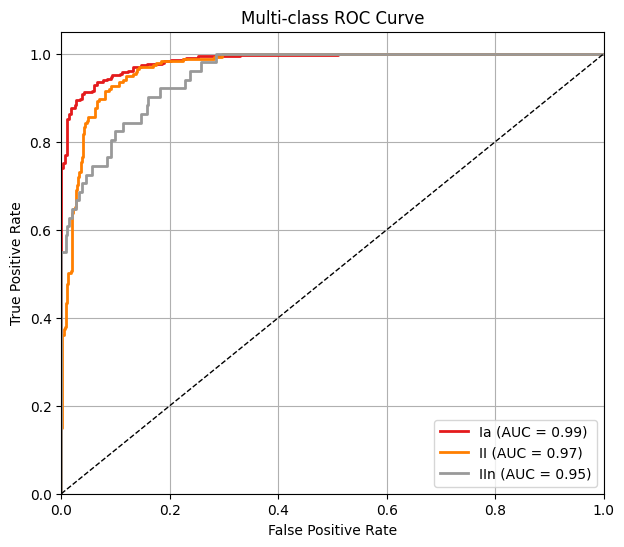

In [80]:
# Model 2 with downsampling
II_bdt_down = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

II_bdt_down.fit(II_X_train_down, II_y_train_down, eval_set=[(II_X_test_down, II_y_test_down)])
evaluate_model(II_bdt_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_labels)

Observation: Model 2 outperforms Model 1 with or without downsampling. Though downsampling seems to make it worse for the classifier, the effect is not as strong as the other two classifiers.

Conclusion:
- Data preprocessing is very important, which in our case is necessary to handle outliers.
- Model 2 outperforms Model 1. Probably because it has more features.
- Boosted decision tree classifier is the most effective, which agrees with the paper.
- Downsampling does not improve classification. The reason might be that our downsampling process results in a too small dataset, making it difficult for the classifiers to learn.
- In Model 2, we did a better job than the paper. Yay 😎!